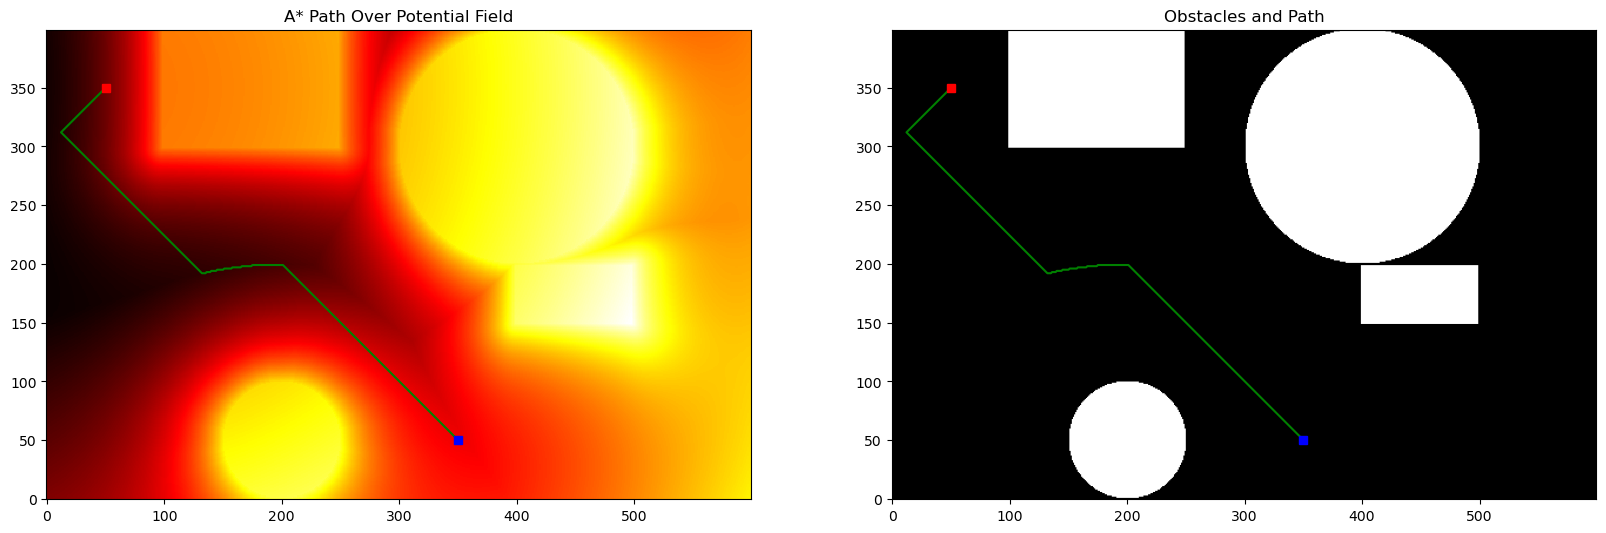

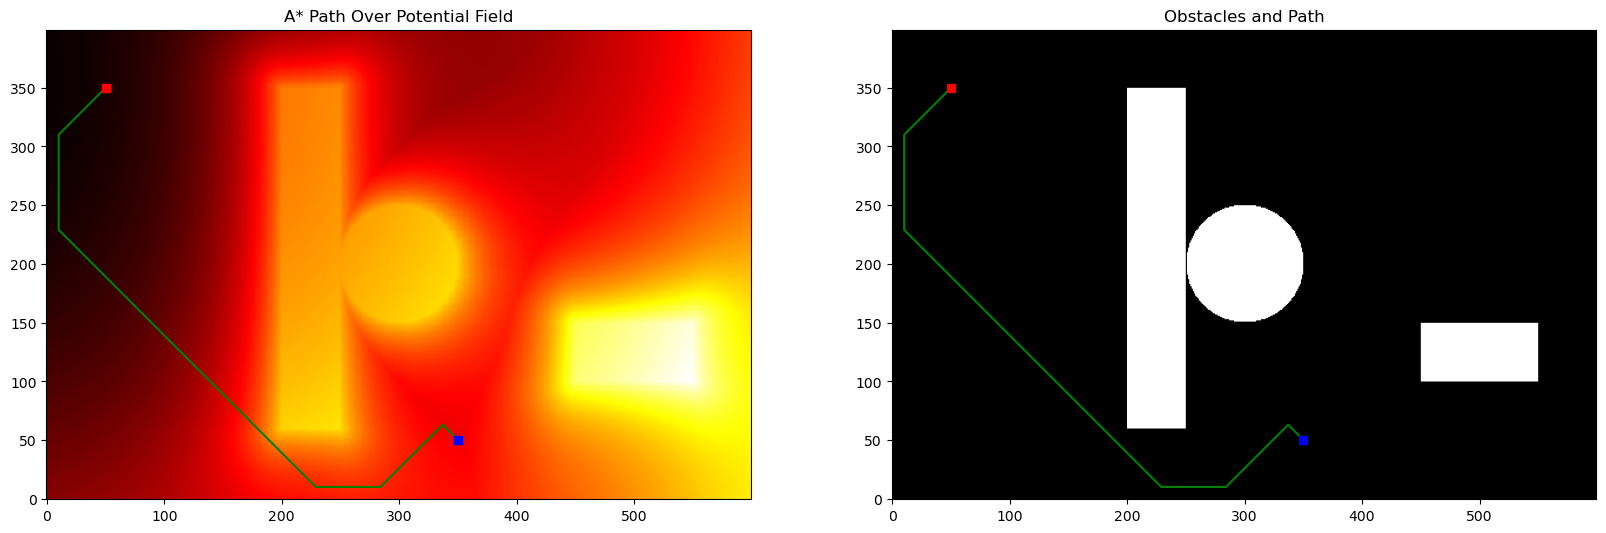

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
import heapq

class PotentialFieldPathDemo:
    def __init__(self):
        self.nrows = 400
        self.ncols = 600
        self.d0 = 20  # Wider influence area for repulsion
        self.nu = 1000  # Higher magnitude to increase repulsion effects
        self.start = np.array([50, 350])  # Y, X format
        self.goal = np.array([350, 50])  # Y, X format
        self.xi = 1 / 400
        self.x, self.y = np.meshgrid(np.arange(self.ncols), np.arange(self.nrows))
        self.maxIter = 1000

    def generateObstacle(self):
        obstacle = np.zeros((self.nrows, self.ncols), dtype=bool)
        obstacle[299:, 99:249] = True
        obstacle[149:199, 399:499] = True
        obstacle[((self.x-200)**2 + (self.y-50)**2) < 50**2] = True
        obstacle[((self.x-400)**2 + (self.y-300)**2) < 100**2] = True
        d = distance_transform_edt(1 - obstacle)
        d2 = d / 100 + 1
        repulsive = self.nu * ((1 / d2 - 1 / self.d0) ** 2)
        repulsive[d2 > self.d0] = 0
        return obstacle, repulsive

    def generateModifiedObstacle(self):
        obstacle = np.zeros((self.nrows, self.ncols), dtype=bool)
        obstacle[60:350, 200:250] = True
        obstacle[100:150, 450:550] = True
        obstacle[((self.x-300)**2 + (self.y-200)**2) < 50**2] = True
        d = distance_transform_edt(1 - obstacle)
        d2 = d / 100 + 1
        repulsive = self.nu * ((1 / d2 - 1 / self.d0) ** 2)
        repulsive[d2 > self.d0] = 0
        return obstacle, repulsive

    def generateAttractive(self):
        attractive = self.xi * ((self.x - self.goal[1])**2 + (self.y - self.goal[0])**2)
        return attractive

    def find_path_with_a_star(self, obstacles, repulsive):
        total_potential = repulsive + self.generateAttractive()
        start = (self.start[1], self.start[0])  # Convert to (x, y)
        goal = (self.goal[1], self.goal[0])
        path = self.a_star_search(start, goal, total_potential, obstacles)

        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(total_potential, origin='lower', cmap='hot', interpolation='nearest')
        if path is not None:
            path = np.array(path)
            plt.plot(path[:, 0], path[:, 1], 'g')
        plt.plot(start[0], start[1], 'bs')  # Start point
        plt.plot(goal[0], goal[1], 'rs')  # Goal point
        plt.title("A* Path Over Potential Field")

        plt.subplot(1, 2, 2)
        plt.imshow(obstacles.astype(int), cmap='gray', origin='lower')
        if path is not None:
            plt.plot(path[:, 0], path[:, 1], 'g')
        plt.plot(start[0], start[1], 'bs')  # Start point
        plt.plot(goal[0], goal[1], 'rs')  # Goal point
        plt.title("Obstacles and Path")

        plt.show()

    def a_star_search(self, start, goal, potential_field, obstacles):
        neighbors = [(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)]
        open_set = []
        heapq.heappush(open_set, (0 + self.heuristic(start, goal), start))
        came_from = {}
        g_score = {start: 0}
        f_score = {start: self.heuristic(start, goal)}

        while open_set:
            current = heapq.heappop(open_set)[1]

            if current == goal:
                return self.reconstruct_path(came_from, current)

            for dx, dy in neighbors:
                neighbor = (current[0] + dx, current[1] + dy)
                # Additional boundary checks to ensure indices are within grid limits
                if 0 <= neighbor[0] < self.ncols and 0 <= neighbor[1] < self.nrows:
                    if obstacles[neighbor[1], neighbor[0]]:
                        continue  # Skip this neighbor if it's an obstacle

                tentative_g_score = g_score[current] + potential_field[neighbor[1], neighbor[0]] + self.cost_to_enter(neighbor, potential_field, obstacles)

                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + self.heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
        return None

    def cost_to_enter(self, pos, potential_field, obstacles):
        """Add a high cost for approaching close to an obstacle."""
        x, y = pos
        cost = 0
        # Check surrounding cells to add cost based on proximity to obstacles
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.ncols and 0 <= ny < self.nrows:
                    if obstacles[ny, nx]:  # directly add high cost for neighboring obstacles
                        cost += 100
                else:
                    cost += 50
        boundary_buffer = 10
        if x < boundary_buffer or x > self.ncols - boundary_buffer:
            cost += 50
        if y < boundary_buffer or y > self.nrows - boundary_buffer:
            cost += 50
        
        return cost


    def heuristic(self, node, goal):
        return np.hypot(node[0] - goal[0], node[1] - goal[1])

    def reconstruct_path(self, came_from, current):
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.append(current)
        return path[::-1]

# Example usage
demo = PotentialFieldPathDemo()
obsmap1, repulmap1 = demo.generateObstacle()
demo.find_path_with_a_star(obsmap1, repulmap1)
obsmap2, repulmap2 = demo.generateModifiedObstacle()
demo.find_path_with_a_star(obsmap2, repulmap2)

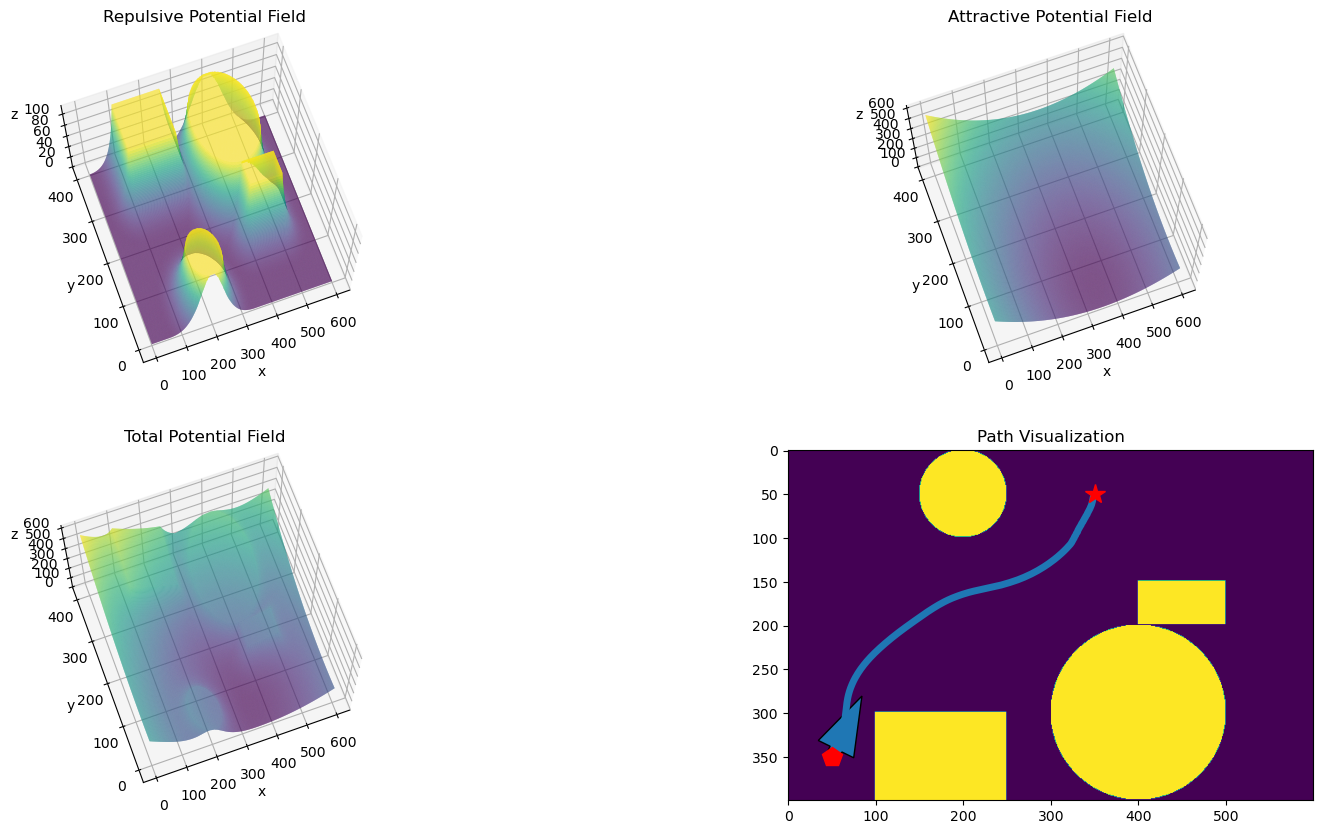

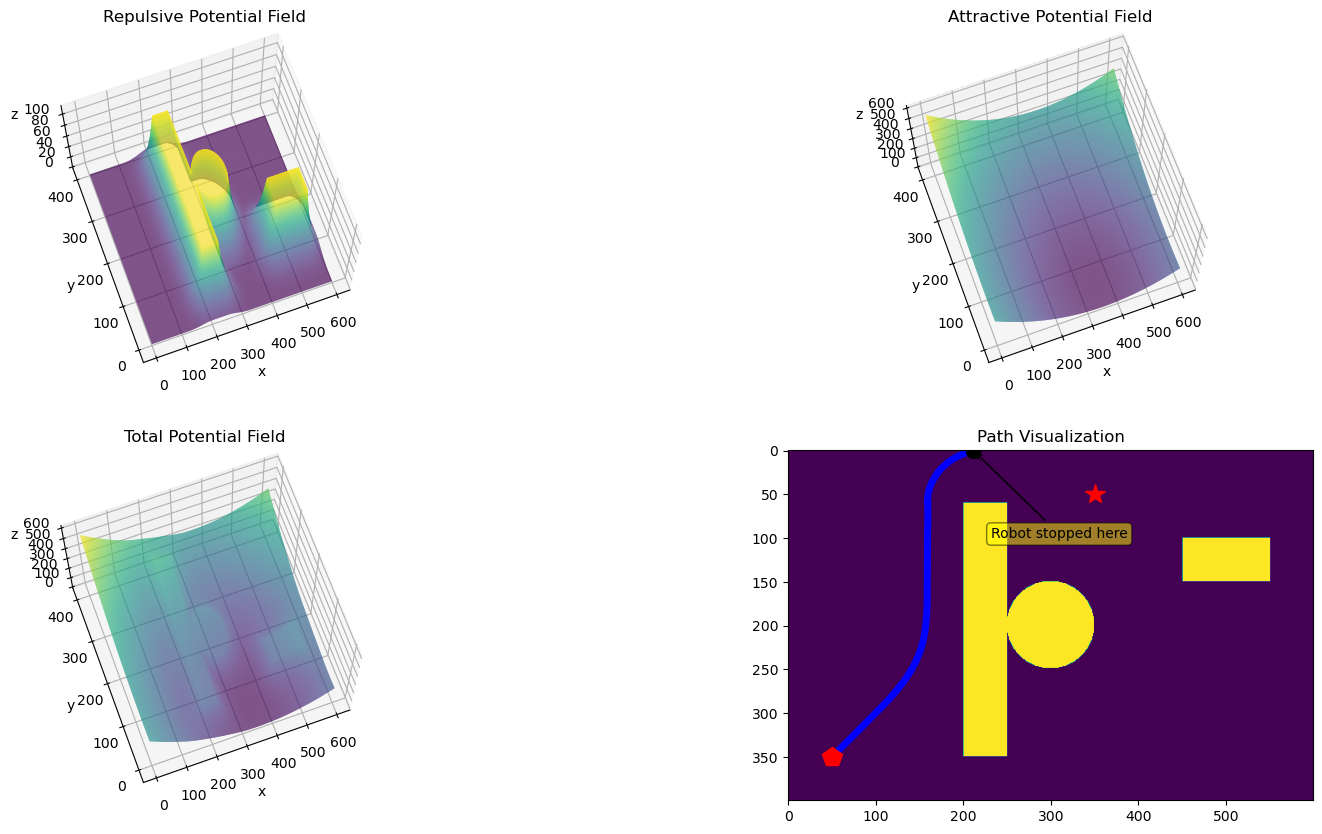

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

def mesh(X, Y, Z):
    """Create a 3D surface plot."""
    ax = plt.gca()
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(70, -110)

def round2(n):
    """Round a number to the nearest integer."""
    return np.floor(n + 0.5).astype(int)

class PotentialFieldPathDemo:
    def __init__(self):
        """Initialize parameters and grid for the potential field."""
        self.nrows = 400
        self.ncols = 600
        self.d0 = 2
        self.nu = 450
        self.start = np.array([50, 350])  # Start position
        self.goal = np.array([350, 50])   # Goal position
        self.xi = 1 / 400
        self.x, self.y = np.meshgrid(np.linspace(1, self.ncols, self.ncols),
                                     np.linspace(1, self.nrows, self.nrows))
        self.maxIter = 1000

    def generateObstacle(self):
        """Generate obstacle configuration and repulsive potential field."""
        obstacle = np.zeros((self.nrows, self.ncols), dtype=bool)
        # Define obstacle areas
        obstacle[299:, 99:249] = True
        obstacle[149:199, 399:499] = True
        # Circular obstacles
        obstacle[((self.x-200)**2 + (self.y-50)**2) < 50**2] = True
        obstacle[((self.x-400)**2 + (self.y-300)**2) < 100**2] = True
        # Calculate distance transform
        d = distance_transform_edt(1 - obstacle)
        d2 = d / 100 + 1  # Normalize distance
        # Calculate repulsive potential
        repulsive = self.nu * ((1 / d2 - 1 / self.d0) ** 2)
        repulsive[d2 > self.d0] = 0  # Cap repulsive potential
        return obstacle, repulsive, self.x, self.y

    def generateAttractive(self):
        """Generate attractive potential field towards the goal."""
        attractive = self.xi * ((self.x - self.goal[0])**2 + (self.y - self.goal[1])**2)
        return attractive, self.x, self.y

    def GradientBasedPlanner(self, f):
        """Gradient-based planner to find a path."""
        # Calculate gradient
        gy, gx = np.gradient(-f)
        route = self.start.reshape(-1, 2).astype(float)
        rate = 1
        current = route[0, :]
        G = np.sqrt(gx**2 + gy**2)
        gx /= G + (G == 0)  # Normalize gradient
        gy /= G + (G == 0)
        tolerance = 2
        # Iterate to find path
        for i in range(self.maxIter):
            tmpx = round2(current[1])
            tmpy = round2(current[0])
            current += rate * np.array([gx[tmpx, tmpy], gy[tmpx, tmpy]])
            # Check if path reaches boundaries
            if np.any(current <= 0) or np.any(current >= [self.ncols, self.nrows]):
                return route, False, current
            # Check if goal reached
            if np.sqrt(np.sum((round2(current) - self.goal)**2)) < tolerance:
                return route, True, current
            route = np.concatenate((route, np.array(current).reshape(-1, 2)))
        return route, False, current

    def generateModifiedObstacle(self):
        """Generate modified obstacle configuration and repulsive potential field."""
        obstacle = np.zeros((self.nrows, self.ncols), dtype=bool)
        # Define modified obstacle areas
        obstacle[60:350, 200:250] = True
        obstacle[100:150, 450:550] = True
        obstacle[((self.x-300)**2 + (self.y-200)**2) < 50**2] = True
        # Calculate distance transform
        d = distance_transform_edt(1 - obstacle)
        d2 = d / 100 + 1  # Normalize distance
        # Calculate repulsive potential
        repulsive = self.nu * ((1 / d2 - 1 / self.d0) ** 2)
        repulsive[d2 > self.d0] = 0  # Cap repulsive potential
        return obstacle, repulsive, self.x, self.y

demo = PotentialFieldPathDemo()

# Map 1
obsmap, repulmap, x, y = demo.generateObstacle()
attmap, _, _ = demo.generateAttractive()
f = repulmap + attmap
route, success, last_position = demo.GradientBasedPlanner(f)

# Visualization of the original scenario
plt.figure(figsize=(20, 10))
plt.subplot(221, projection='3d'); mesh(x, y, repulmap); plt.title("Repulsive Potential Field")
plt.subplot(222, projection='3d'); mesh(x, y, attmap); plt.title("Attractive Potential Field")
plt.subplot(223, projection='3d'); mesh(x, y, f); plt.title("Total Potential Field")
plt.subplot(224)
plt.imshow(obsmap)
plt.plot(route[:, 0], route[:, 1], '-', linewidth=5)
dxdy = route[10, :] - route[0, :]
plt.arrow(route[0, 0], route[0, 1], dxdy[0], dxdy[1], width=15)
plt.plot(demo.start[0], demo.start[1], 'rp', markersize=15)
plt.plot(demo.goal[0], demo.goal[1], 'r*', markersize=15)
plt.title("Path Visualization")


# Map 2
obsmap2, repulmap2, x2, y2 = demo.generateModifiedObstacle()
attmap2, _, _ = demo.generateAttractive()
f2 = repulmap2 + attmap2
route2, success2, last_position2 = demo.GradientBasedPlanner(f2)

from matplotlib.patches import Rectangle

def adjust_text_position(ax, x, y):
    """Dynamically adjust text position."""
    text_x = x + 20
    text_y = y - 20
    if x > demo.ncols - 100:  # Close to right edge
        text_x = x - 100
    if y < 100:  # Close to top
        text_y = y + 100
    return text_x, text_y

# Visualization setup
plt.figure(figsize=(20, 10))
subplot_details = [(221, repulmap2, "Repulsive Potential Field"),
                   (222, attmap2, "Attractive Potential Field"),
                   (223, f2

, "Total Potential Field"),
                   (224, obsmap2, "Path Visualization")]

for subplot_idx, data, title in subplot_details:
    ax = plt.subplot(subplot_idx, projection='3d' if subplot_idx != 224 else None)
    if subplot_idx == 224:
        ax.imshow(data)
        ax.plot(route2[:, 0], route2[:, 1], '-', linewidth=5, color='blue')
        ax.plot(demo.start[0], demo.start[1], 'rp', markersize=15)  # Start point
        ax.plot(demo.goal[0], demo.goal[1], 'r*', markersize=15)  # Goal point
        if not success2:
            ax.plot(last_position2[0], last_position2[1], 'ko', markersize=10)  # Endpoint
            # Adjust text position
            text_x, text_y = adjust_text_position(ax, last_position2[0], last_position2[1])
            ax.annotate('Robot stopped here', xy=(last_position2[0], last_position2[1]), xytext=(text_x, text_y),
                        textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='black'),
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', edgecolor='black', alpha=0.5))
    else:
        mesh(x2, y2, data)
    plt.title(title)

plt.show()

In [20]:
```python
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
import heapq

class PotentialFieldPathDemo:
    def __init__(self):
        """
        Initialize the parameters and grid for the potential field path planning demo.
        """
        self.nrows = 400  # Number of rows in the grid
        self.ncols = 600  # Number of columns in the grid
        self.d0 = 20  # Wider influence area for repulsion
        self.nu = 1000  # Higher magnitude to increase repulsion effects
        self.start = np.array([50, 350])  # Start position (Y, X format)
        self.goal = np.array([350, 50])  # Goal position (Y, X format)
        self.xi = 1 / 400  # Attractive potential factor
        self.x, self.y = np.meshgrid(np.arange(self.ncols), np.arange(self.nrows))  # 2D grid coordinates
        self.maxIter = 1000  # Maximum number of iterations for path planning

    def generateObstacle(self):
        """
        Generate obstacle map and repulsive potential field.

        Returns:
        - obstacle: 2D boolean array representing obstacle locations.
        - repulsive: 2D array representing the repulsive potential field.
        """
        obstacle = np.zeros((self.nrows, self.ncols), dtype=bool)
        obstacle[299:, 99:249] = True
        obstacle[149:199, 399:499] = True
        obstacle[((self.x-200)**2 + (self.y-50)**2) < 50**2] = True
        obstacle[((self.x-400)**2 + (self.y-300)**2) < 100**2] = True
        d = distance_transform_edt(1 - obstacle)
        d2 = d / 100 + 1  # Normalize distance to 100
        repulsive = self.nu * ((1 / d2 - 1 / self.d0) ** 2)  # Repulsive potential calculation
        repulsive[d2 > self.d0] = 0  # Clamp values greater than d0
        return obstacle, repulsive

    def generateModifiedObstacle(self):
        """
        Generate modified obstacle map and repulsive potential field.

        Returns:
        - obstacle: 2D boolean array representing obstacle locations.
        - repulsive: 2D array representing the repulsive potential field.
        """
        obstacle = np.zeros((self.nrows, self.ncols), dtype=bool)
        obstacle[60:350, 200:250] = True
        obstacle[100:150, 450:550] = True
        obstacle[((self.x-300)**2 + (self.y-200)**2) < 50**2] = True
        d = distance_transform_edt(1 - obstacle)
        d2 = d / 100 + 1  # Normalize distance to 100
        repulsive = self.nu * ((1 / d2 - 1 / self.d0) ** 2)  # Repulsive potential calculation
        repulsive[d2 > self.d0] = 0  # Clamp values greater than d0
        return obstacle, repulsive

    def generateAttractive(self):
        """
        Generate the attractive potential field.

        Returns:
        - attractive: 2D array representing the attractive potential field.
        """
        attractive = self.xi * ((self.x - self.goal[1])**2 + (self.y - self.goal[0])**2)  # Attractive potential calculation
        return attractive

    def find_path_with_a_star(self, obstacles, repulsive):
        """
        Find the path from start to goal using A* search over the potential field.

        Args:
        - obstacles: 2D boolean array representing obstacle locations.
        - repulsive: 2D array representing the repulsive potential field.
        """
        total_potential = repulsive + self.generateAttractive()  # Total potential combining repulsive and attractive fields
        start = (self.start[1], self.start[0])  # Convert to (x, y) format
        goal = (self.goal[1], self.goal[0])
        path = self.a_star_search(start, goal, total_potential, obstacles)  # Find path using A* search

        # Visualization of potential field and path
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(total_potential, origin='lower', cmap='hot', interpolation='nearest')
        if path is not None:
            path = np.array(path)
            plt.plot(path[:, 0], path[:, 1], 'g')
        plt.plot(start[0], start[1], 'bs')  # Start point
        plt.plot(goal[0], goal[1], 'rs')  # Goal point
        plt.title("A* Path Over Potential Field")

        plt.subplot(1, 2, 2)
        plt.imshow(obstacles.astype(int), cmap='gray', origin='lower')
        if path is not None:
            plt.plot(path[:, 0], path[:, 1], 'g')
        plt.plot(start[0], start[1], 'bs')  # Start point
        plt.plot(goal[0], goal[1], 'rs')  # Goal point
        plt.title("Obstacles and Path")

        plt.show()

    def a_star_search(self, start, goal, potential_field, obstacles):
        """
        Perform A* search to find the path from start to goal over the potential field.

        Args:
        - start: Tuple representing the start position (x, y).
        - goal: Tuple representing the goal position (x, y).
        - potential_field: 2D array representing the total potential field.
        - obstacles: 2D boolean array representing obstacle locations.

        Returns:
        - path: List of tuples representing the path from start to goal.
        """
        neighbors = [(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)]  # Possible neighbor movements
        open_set = []  # Priority queue for nodes to be evaluated
        heapq.heappush(open_set, (0 + self.heuristic(start, goal), start))  # Push start node to open set with priority
        came_from = {}  # Dictionary to store the parent of each node
        g_score = {start: 0}  # Dictionary to store the cost from start to each node
        f_score = {start: self.heuristic(start, goal)}  # Dictionary to store the total cost from start to each node

        while open_set:
            current = heapq.heappop(open_set)[1]  # Pop the node with the lowest total cost from open set

            if current == goal:
                return self.reconstruct_path(came_from, current)  # Reconstruct path if goal is reached

            for dx, dy in neighbors:
                neighbor = (current[0] + dx, current[1] + dy)
                # Additional boundary

 checks to ensure indices are within grid limits
                if 0 <= neighbor[0] < self.ncols and 0 <= neighbor[1] < self.nrows:
                    if obstacles[neighbor[1], neighbor[0]]:
                        continue  # Skip this neighbor if it's an obstacle

                tentative_g_score = g_score[current] + potential_field[neighbor[1], neighbor[0]] + self.cost_to_enter(neighbor, potential_field, obstacles)

                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + self.heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))  # Push neighbor to open set with priority

        return None

    def cost_to_enter(self, pos, potential_field, obstacles):
        """
        Calculate the cost to enter a cell based on its position and surrounding obstacles.

        Args:
        - pos: Tuple representing the position (x, y) of the cell.
        - potential_field: 2D array representing the total potential field.
        - obstacles: 2D boolean array representing obstacle locations.

        Returns:
        - cost: Cost to enter the cell.
        """
        x, y = pos
        cost = 0
        # Check surrounding cells to add cost based on proximity to obstacles
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.ncols and 0 <= ny < self.nrows:
                    if obstacles[ny, nx]:  # Add high cost for neighboring obstacles
                        cost += 100
                else:
                    cost += 50
        boundary_buffer = 10  # Buffer zone around the grid boundary
        if x < boundary_buffer or x > self.ncols - boundary_buffer:
            cost += 50
        if y < boundary_buffer or y > self.nrows - boundary_buffer:
            cost += 50
        
        return cost

    def heuristic(self, node, goal):
        """
        Calculate the heuristic (Euclidean distance) from a node to the goal.

        Args:
        - node: Tuple representing the node position (x, y).
        - goal: Tuple representing the goal position (x, y).

        Returns:
        - heuristic: Euclidean distance from the node to the goal.
        """
        return np.hypot(node[0] - goal[0], node[1] - goal[1])

    def reconstruct_path(self, came_from, current):
        """
        Reconstruct the path from start to goal using the came_from dictionary.

        Args:
        - came_from: Dictionary containing the parent of each node in the path.
        - current: Tuple representing the current node position (x, y).

        Returns:
        - path: List of tuples representing the path from start to goal.
        """
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.append(current)
        return path[::-1]

# Example usage
demo = PotentialFieldPathDemo()
obsmap1, repulmap1 = demo.generateObstacle()
demo.find_path_with_a_star(obsmap1, repulmap1)
obsmap2, repulmap2 = demo.generateModifiedObstacle()
demo.find_path_with_a_star(obsmap2, repulmap2)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 133)